In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
from collections import OrderedDict

cmaps = OrderedDict()

In [18]:
import numpy as np
import pandas as pd

In [38]:
import datetime as dt
from sqlalchemy import create_engine, inspect

# Reflect Tables into SQLAlchemy ORM

In [45]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [46]:
engine = create_engine("sqlite:///resources/hawaii.sqlite", echo=False)

In [47]:
inspector = inspect(engine)

In [48]:
inspector.get_table_names()

['measurement', 'station']

In [49]:
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [59]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [50]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [51]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [52]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [53]:
# Save references to each table
Measurement = Base.classes.measurement
StationTable = Base.classes.station

In [54]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

In [69]:
# Design a query to retrieve the last 12 months of precipitation data.
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = last_date[0]
year_ago = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=366) 

print(last_date)
print(last_year)


2017-08-23
2016-08-23


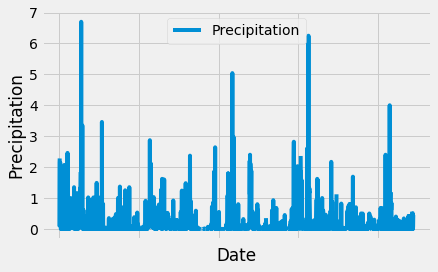

In [70]:
# Perform a query to retrieve the data and precipitation score

precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_year).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data)

precipitation_df.set_index('date', inplace=True)
precipitation_df.head()

# Sort the dataframe by date
precipitation_df.sort_values(by='date', ascending=False)
 
# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot()
plt.tight_layout()
# plt.title(“Precipitation by Date for Hawaii”)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend(["Precipitation"])
plt.show()

In [71]:
# Use Pandas to calculate the summary statistics for the precipitation data

precipitation_df.rename(columns={'prcp':'Precipitation Stats'}, inplace=True)
precipitation_df.describe()

,Summary Statistics for Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [82]:
station_count = session.query(StationTable.station).count()
print(station_count)


9


In [88]:
most_active_stations = session.query(StationTable.name, StationTable.id).group_by('name')
print(most_active_stations)

AttributeError: 'int' object has no attribute 'group_by'

In [79]:
 stations_data = session.query(StationTable.station, StationTable.name)
print(stations_data)

SELECT station.station AS station_station, station.name AS station_name 
FROM station


In [74]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

precipitation_data = pd.read_sql("SELECT id, station FROM Measurement", conn).dropna(axis=0)
active_stations = precipitation_data.groupby('station').count()
active_stations_count =pd.DataFrame(active_stations)
active_stations_count.rename(columns={'station':'Station id', 'id': 'Data Count Per Station'}, inplace=True)
active_stations_count.sort_values('Data Count Per Station', ascending= False)


,Data Count Per Station
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [76]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
#highest temperature recorded, and average temperature most active station?

most_active = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == "USC00519281").all()

most_active


[(54.0, 85.0, 71.66378066378067)]

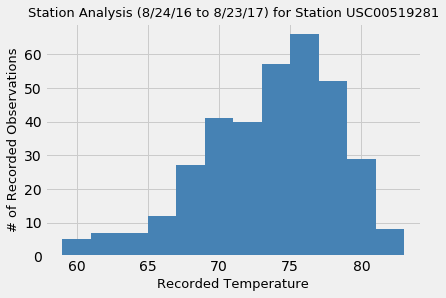

In [77]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_data = session.query(Measurement.date, Measurement.prcp, Measurement.tobs).filter(Measurement.date > last_year).\
filter(Measurement.station == "USC00519281").order_by(Measurement.date).all()

active_station_df =pd.DataFrame(active_station_data)
plt.hist(active_station_df['tobs'],12, color='steelblue')
plt.xlabel("Recorded Temperature", size =13)
plt.ylabel("# of Recorded Observations",size =13)
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station USC00519281", size =13)
plt.show()